# 1. import necessary packages.

In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 2. prepare training set and testing set which contain frauds.

In [2]:
# import original training and testing data sets.
df = pd.read_csv('../../input/fashion-mnist_train.csv', skiprows=[0], header=None)
df_2 = pd.read_csv('../../input/fashion-mnist_test.csv', skiprows=[0], header=None)

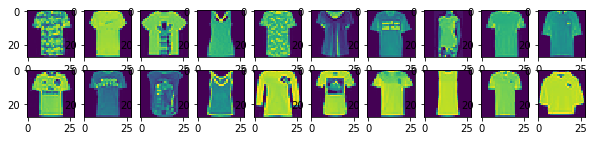

In [3]:
# found out each category contains 6000 images in the training dataset. df.shape = (60000, 785)
df.groupby(0)[0].value_counts()
# found out each category contains 1000 images in the training dataset. df_2.shape = (10000, 785)
df_2.groupby(0)[0].value_counts()
# plot category 0: represent for T-shirt/Tops.
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    a[0][i].imshow(np.reshape(df.iloc[df[df[0]==0].index[i], 1:].values, (28, 28)))
    a[1][i].imshow(np.reshape(df_2.iloc[df_2[df_2[0]==0].index[i], 1:].values, (28, 28)))

In [4]:
# cut training datasets for 0 category.
df_1 = df.drop(df[df[0]==0].index)
# remain all category 0 in testing data sets as a fraud image.
df_2 = df_2

In [5]:
# create cleaned datasets for training and testing.
x_train = np.float32(df_1.iloc[:,1:].values)/255.0
x_test = np.float32(df_2.iloc[:,1:].values)/255.0
num_samples = x_train.shape[0]
num_cols = x_train.shape[1]

# 3. tensorflow graph input.

In [6]:
# model parameters.
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters.
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = num_cols # MNIST data input (img shape: 28*28)

# tensorflow graph declaration.
X = tf.placeholder(tf.float32, [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

# 4. build up autoencoder model.

In [7]:
# Building the encoder
def encoder(x):
    # Encoder first layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder second layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

In [8]:
# Building the decoder
def decoder(x):
    # Decoder first layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder second layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [9]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

# 5. feed training data into this built-up graph.

In [10]:
# create a object for getting the Batch.
class Batch(object):
  def __init__(self, x, batch_size):
    self.batch_size = batch_size
    self.x = x
    self.size = x.shape[0]
  def getBatch(self):
    indices = np.random.randint(self.size, size=self.batch_size)
    return self.x[indices, :]

In [11]:
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(num_samples/batch_size)
batch = Batch(x_train, batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = batch.getBatch()
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.195513293
Epoch: 0002 cost= 0.156877205
Epoch: 0003 cost= 0.148980200
Epoch: 0004 cost= 0.137293890
Epoch: 0005 cost= 0.130380049
Epoch: 0006 cost= 0.127449632
Epoch: 0007 cost= 0.119935453
Epoch: 0008 cost= 0.128089279
Epoch: 0009 cost= 0.119687594
Epoch: 0010 cost= 0.111590967
Epoch: 0011 cost= 0.113681920
Epoch: 0012 cost= 0.112557232
Epoch: 0013 cost= 0.110004954
Epoch: 0014 cost= 0.107396729
Epoch: 0015 cost= 0.109014235
Epoch: 0016 cost= 0.107292555
Epoch: 0017 cost= 0.106769949
Epoch: 0018 cost= 0.102414981
Epoch: 0019 cost= 0.103422508
Epoch: 0020 cost= 0.103810079
Optimization Finished!


# 6. test the encoder-decoder model for category 0 vs category 1-9.

In [12]:
# Applying encode and decode over test set for category K.
K_fraud = 0
encode_decode_fraud = sess.run(
    y_pred, feed_dict={X: x_test[df_2[df_2[0]==K_fraud].index]})

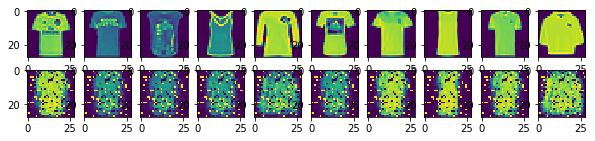

In [13]:
# Compare original images with their reconstructions for category K.
f, a = plt.subplots(2, 10, figsize=(10, 2))
#plt.set_cmap('Greys')
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_test[df_2[df_2[0]==K_fraud].index[i]], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode_fraud[i], (28, 28)))

In [14]:
# Applying encode and decode over test set for category K.
K_good = 0
encode_decode_good = sess.run(
    y_pred, feed_dict={X: x_test[df_2[df_2[0]!=K_good].index]})

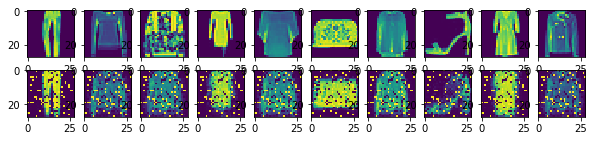

In [15]:
# Compare original images with their reconstructions for category K.
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_test[df_2[df_2[0]!=K_good].index[i]], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode_good[i], (28, 28)))

# 7. explore different metric to detect this fraud.

## a. using reconstruction MSE.

In [16]:
# reconstruction SSE[i] == summation_over_each_pixel((x_test - encoder-decoder)^2)
K_fraud = 0
SSE_fraud = [np.sum((x_test[df_2[df_2[0]==K_fraud].index[i]]-encode_decode_fraud[i])**2) for i in range(len(encode_decode_fraud))]

In [17]:
MSE_fraud = [SSE_fraud[i]/784 for i in range(len(encode_decode_fraud))]

In [18]:
# reconstruction SSE[i] == summation_over_each_pixel((x_test - encoder-decoder)^2)
K_good = 0
SSE_good = [np.sum((x_test[df_2[df_2[0]!=K_good].index[i]]-encode_decode_good[i])**2) for i in range(len(encode_decode_good))]

In [19]:
MSE_good = [SSE_good[i]/784 for i in range(len(encode_decode_good))]

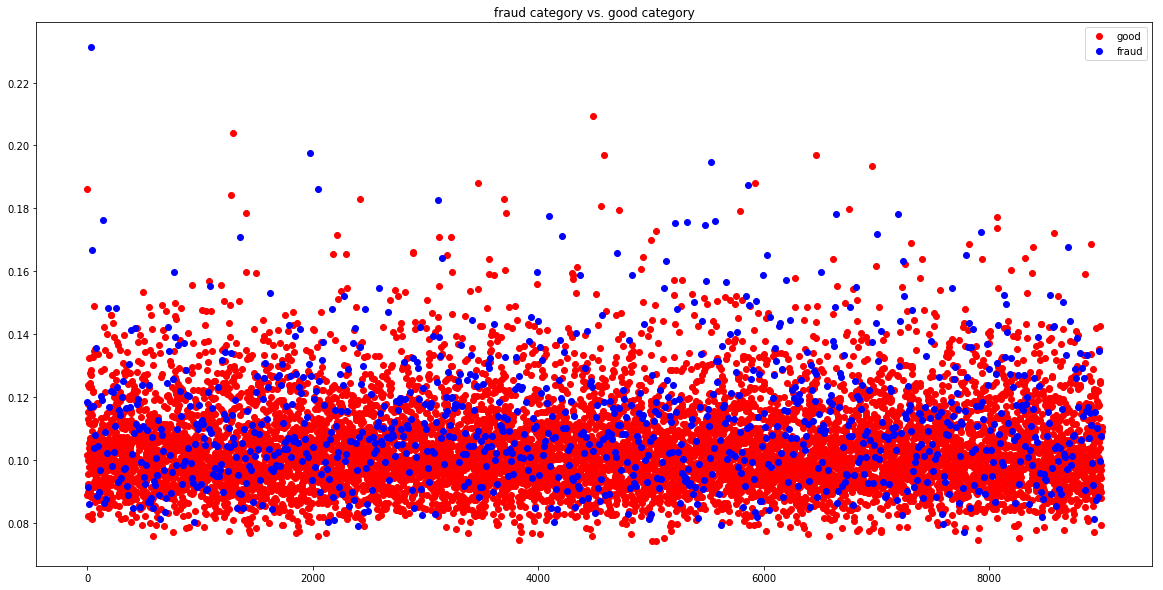

In [20]:
# plot fraud on top of good image. The difference is not good enough for a classifier.
plt.figure(figsize=(20,10))
plt.title('fraud category vs. good category')
plt.plot(range(len(MSE_good)), MSE_good, 'ro', range(0, len(MSE_good), len(MSE_good)//len(MSE_fraud)), MSE_fraud, 'bo')
plt.legend(['good', 'fraud'])

## b. more metrics comparison coming here...